# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

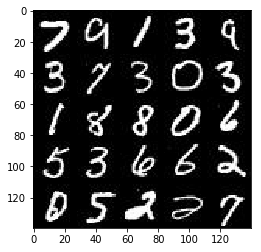

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

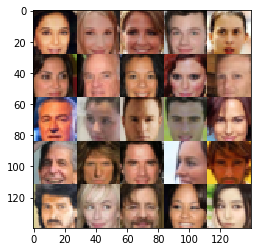

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='lr')

    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=0.05))
        relu1 = tf.maximum(alpha * x1, x1)
      
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=0.05))
        n2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * n2, n2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=0.05))
        n3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * n3, n3)
        
        x4 = tf.layers.conv2d(relu3, 512, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=0.05))
        n4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * n4, n4)

        flat = tf.reshape(relu4, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse = not is_train
    
    with tf.variable_scope('generator', reuse=reuse):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=0.05))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=0.05))
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=0.05))
        out = tf.tanh(logits) 
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, alpha=alpha)

    d_model_real, d_logits_real = discriminator(input_real, reuse=False, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                          labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                          labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
             tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                     labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    i = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                i += 1
                batch_images =  batch_images * 2.0
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, lr: learning_rate})
                
                if i % 100 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                
                if i % 10 == 0:                    
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 6.0117... Generator Loss: 0.0077
Epoch 1/2... Discriminator Loss: 4.2866... Generator Loss: 0.0869
Epoch 1/2... Discriminator Loss: 4.6122... Generator Loss: 0.0235
Epoch 1/2... Discriminator Loss: 3.2458... Generator Loss: 0.0882
Epoch 1/2... Discriminator Loss: 3.7159... Generator Loss: 0.0506
Epoch 1/2... Discriminator Loss: 3.0223... Generator Loss: 0.1186
Epoch 1/2... Discriminator Loss: 3.6485... Generator Loss: 0.0521
Epoch 1/2... Discriminator Loss: 3.7376... Generator Loss: 0.0401
Epoch 1/2... Discriminator Loss: 1.6443... Generator Loss: 0.4821


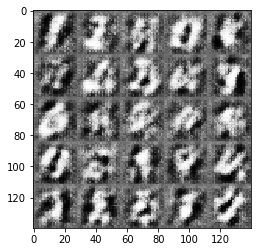

Epoch 1/2... Discriminator Loss: 2.8446... Generator Loss: 0.0957
Epoch 1/2... Discriminator Loss: 3.1295... Generator Loss: 0.0801
Epoch 1/2... Discriminator Loss: 2.7491... Generator Loss: 0.1752
Epoch 1/2... Discriminator Loss: 1.6309... Generator Loss: 0.8021
Epoch 1/2... Discriminator Loss: 1.2026... Generator Loss: 1.1359
Epoch 1/2... Discriminator Loss: 1.0486... Generator Loss: 1.4504
Epoch 1/2... Discriminator Loss: 1.6406... Generator Loss: 0.4721
Epoch 1/2... Discriminator Loss: 1.5728... Generator Loss: 0.6401
Epoch 1/2... Discriminator Loss: 1.9285... Generator Loss: 0.2569
Epoch 1/2... Discriminator Loss: 1.2768... Generator Loss: 0.7428


Epoch 1/2... Discriminator Loss: 1.8386... Generator Loss: 0.3264
Epoch 1/2... Discriminator Loss: 1.8182... Generator Loss: 1.3791
Epoch 1/2... Discriminator Loss: 1.6929... Generator Loss: 0.3938
Epoch 1/2... Discriminator Loss: 1.5476... Generator Loss: 0.4074
Epoch 1/2... Discriminator Loss: 1.9042... Generator Loss: 0.2676
Epoch 1/2... Discriminator Loss: 2.0480... Generator Loss: 0.2129
Epoch 1/2... Discriminator Loss: 2.1073... Generator Loss: 0.2065
Epoch 1/2... Discriminator Loss: 1.0043... Generator Loss: 1.4120
Epoch 1/2... Discriminator Loss: 1.3859... Generator Loss: 0.5356
Epoch 1/2... Discriminator Loss: 1.1825... Generator Loss: 1.0795


Epoch 1/2... Discriminator Loss: 1.4955... Generator Loss: 0.6590
Epoch 1/2... Discriminator Loss: 2.9163... Generator Loss: 0.1020
Epoch 1/2... Discriminator Loss: 1.2966... Generator Loss: 0.6505
Epoch 1/2... Discriminator Loss: 1.2515... Generator Loss: 0.7119
Epoch 1/2... Discriminator Loss: 1.1272... Generator Loss: 0.6460
Epoch 1/2... Discriminator Loss: 1.2645... Generator Loss: 0.9160
Epoch 1/2... Discriminator Loss: 1.2159... Generator Loss: 0.8220
Epoch 1/2... Discriminator Loss: 1.1491... Generator Loss: 0.7471
Epoch 1/2... Discriminator Loss: 0.8454... Generator Loss: 1.5695
Epoch 1/2... Discriminator Loss: 1.5639... Generator Loss: 0.6303


Epoch 1/2... Discriminator Loss: 1.8045... Generator Loss: 0.3089
Epoch 1/2... Discriminator Loss: 2.0580... Generator Loss: 0.2183
Epoch 1/2... Discriminator Loss: 2.3386... Generator Loss: 0.1896
Epoch 1/2... Discriminator Loss: 1.0493... Generator Loss: 1.4590
Epoch 1/2... Discriminator Loss: 1.8282... Generator Loss: 0.2823
Epoch 1/2... Discriminator Loss: 1.6790... Generator Loss: 0.3836
Epoch 1/2... Discriminator Loss: 1.6935... Generator Loss: 0.3390
Epoch 1/2... Discriminator Loss: 1.4771... Generator Loss: 0.4041
Epoch 1/2... Discriminator Loss: 1.3273... Generator Loss: 0.8413
Epoch 1/2... Discriminator Loss: 1.3064... Generator Loss: 0.6099


Epoch 1/2... Discriminator Loss: 1.7559... Generator Loss: 2.2811
Epoch 1/2... Discriminator Loss: 1.4658... Generator Loss: 0.4435
Epoch 1/2... Discriminator Loss: 1.7856... Generator Loss: 0.3211
Epoch 1/2... Discriminator Loss: 1.6668... Generator Loss: 0.5662
Epoch 1/2... Discriminator Loss: 0.9854... Generator Loss: 1.1849
Epoch 1/2... Discriminator Loss: 1.5069... Generator Loss: 0.4370
Epoch 1/2... Discriminator Loss: 1.2281... Generator Loss: 1.5596
Epoch 1/2... Discriminator Loss: 1.2195... Generator Loss: 1.5375
Epoch 1/2... Discriminator Loss: 1.1618... Generator Loss: 0.7237
Epoch 1/2... Discriminator Loss: 1.1287... Generator Loss: 0.7278


Epoch 1/2... Discriminator Loss: 1.7171... Generator Loss: 3.5055
Epoch 1/2... Discriminator Loss: 1.1269... Generator Loss: 1.0695
Epoch 1/2... Discriminator Loss: 1.9081... Generator Loss: 0.2581
Epoch 1/2... Discriminator Loss: 1.4299... Generator Loss: 0.4625
Epoch 1/2... Discriminator Loss: 1.2427... Generator Loss: 0.5872
Epoch 1/2... Discriminator Loss: 1.7861... Generator Loss: 0.3306
Epoch 1/2... Discriminator Loss: 1.0266... Generator Loss: 1.1184
Epoch 1/2... Discriminator Loss: 1.7415... Generator Loss: 0.3122
Epoch 1/2... Discriminator Loss: 0.9292... Generator Loss: 1.0051
Epoch 1/2... Discriminator Loss: 1.8874... Generator Loss: 0.2578


Epoch 1/2... Discriminator Loss: 0.8952... Generator Loss: 1.6360
Epoch 1/2... Discriminator Loss: 1.1728... Generator Loss: 0.7543
Epoch 1/2... Discriminator Loss: 1.0858... Generator Loss: 1.6629
Epoch 1/2... Discriminator Loss: 0.9414... Generator Loss: 1.9496
Epoch 1/2... Discriminator Loss: 1.6617... Generator Loss: 0.3658
Epoch 1/2... Discriminator Loss: 1.4357... Generator Loss: 0.4728
Epoch 1/2... Discriminator Loss: 2.0293... Generator Loss: 0.2662
Epoch 1/2... Discriminator Loss: 0.9602... Generator Loss: 1.4474
Epoch 1/2... Discriminator Loss: 1.8482... Generator Loss: 0.4026
Epoch 1/2... Discriminator Loss: 1.4640... Generator Loss: 0.4903


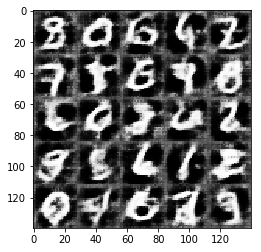

Epoch 1/2... Discriminator Loss: 1.2314... Generator Loss: 0.6449
Epoch 1/2... Discriminator Loss: 1.3856... Generator Loss: 0.5571
Epoch 1/2... Discriminator Loss: 1.1277... Generator Loss: 0.7965
Epoch 1/2... Discriminator Loss: 0.9169... Generator Loss: 1.0129
Epoch 1/2... Discriminator Loss: 2.0042... Generator Loss: 0.2690
Epoch 1/2... Discriminator Loss: 1.1390... Generator Loss: 0.6980
Epoch 1/2... Discriminator Loss: 2.0110... Generator Loss: 0.2141
Epoch 1/2... Discriminator Loss: 1.0833... Generator Loss: 0.7590
Epoch 1/2... Discriminator Loss: 1.3050... Generator Loss: 0.5634
Epoch 1/2... Discriminator Loss: 0.8483... Generator Loss: 1.5511


Epoch 1/2... Discriminator Loss: 1.6695... Generator Loss: 0.3455
Epoch 1/2... Discriminator Loss: 1.2249... Generator Loss: 0.6823
Epoch 1/2... Discriminator Loss: 1.1860... Generator Loss: 0.7783
Epoch 1/2... Discriminator Loss: 1.6646... Generator Loss: 0.3770
Epoch 1/2... Discriminator Loss: 0.9092... Generator Loss: 0.9884
Epoch 1/2... Discriminator Loss: 1.1807... Generator Loss: 0.6358
Epoch 1/2... Discriminator Loss: 1.0562... Generator Loss: 0.7337
Epoch 1/2... Discriminator Loss: 1.9796... Generator Loss: 0.2792
Epoch 1/2... Discriminator Loss: 0.9651... Generator Loss: 0.8691
Epoch 1/2... Discriminator Loss: 2.1340... Generator Loss: 0.2240


Epoch 1/2... Discriminator Loss: 1.6955... Generator Loss: 0.3748
Epoch 1/2... Discriminator Loss: 1.1907... Generator Loss: 0.6609
Epoch 1/2... Discriminator Loss: 0.8652... Generator Loss: 1.1297
Epoch 1/2... Discriminator Loss: 1.2526... Generator Loss: 0.7618
Epoch 1/2... Discriminator Loss: 2.1488... Generator Loss: 0.2200
Epoch 1/2... Discriminator Loss: 1.3051... Generator Loss: 0.5942
Epoch 1/2... Discriminator Loss: 2.6953... Generator Loss: 0.1290
Epoch 1/2... Discriminator Loss: 1.0225... Generator Loss: 0.9577
Epoch 1/2... Discriminator Loss: 1.6073... Generator Loss: 0.5383
Epoch 1/2... Discriminator Loss: 0.9288... Generator Loss: 1.0695


Epoch 1/2... Discriminator Loss: 1.0263... Generator Loss: 1.5581
Epoch 1/2... Discriminator Loss: 1.2410... Generator Loss: 0.5731
Epoch 1/2... Discriminator Loss: 0.7949... Generator Loss: 1.2558
Epoch 1/2... Discriminator Loss: 2.9181... Generator Loss: 0.1251
Epoch 1/2... Discriminator Loss: 0.7983... Generator Loss: 1.2049
Epoch 1/2... Discriminator Loss: 0.6632... Generator Loss: 2.0869
Epoch 1/2... Discriminator Loss: 2.6533... Generator Loss: 0.1265
Epoch 1/2... Discriminator Loss: 0.7417... Generator Loss: 1.4397
Epoch 1/2... Discriminator Loss: 1.3887... Generator Loss: 0.5084
Epoch 1/2... Discriminator Loss: 3.0879... Generator Loss: 0.1165


Epoch 1/2... Discriminator Loss: 1.1634... Generator Loss: 0.6766
Epoch 1/2... Discriminator Loss: 1.0433... Generator Loss: 0.8030
Epoch 1/2... Discriminator Loss: 1.4249... Generator Loss: 0.5486
Epoch 1/2... Discriminator Loss: 1.2895... Generator Loss: 0.6954
Epoch 1/2... Discriminator Loss: 0.6183... Generator Loss: 2.1191
Epoch 1/2... Discriminator Loss: 1.5689... Generator Loss: 0.4275
Epoch 1/2... Discriminator Loss: 1.8075... Generator Loss: 0.3256
Epoch 1/2... Discriminator Loss: 1.6758... Generator Loss: 0.4103
Epoch 1/2... Discriminator Loss: 0.8455... Generator Loss: 1.0923
Epoch 1/2... Discriminator Loss: 1.3061... Generator Loss: 0.5851


Epoch 1/2... Discriminator Loss: 0.6679... Generator Loss: 1.7795
Epoch 1/2... Discriminator Loss: 1.9484... Generator Loss: 0.3075
Epoch 1/2... Discriminator Loss: 0.6793... Generator Loss: 1.5788
Epoch 1/2... Discriminator Loss: 1.1518... Generator Loss: 0.7120
Epoch 1/2... Discriminator Loss: 1.5257... Generator Loss: 0.4258
Epoch 1/2... Discriminator Loss: 1.6785... Generator Loss: 0.4302
Epoch 1/2... Discriminator Loss: 1.4081... Generator Loss: 0.5935
Epoch 1/2... Discriminator Loss: 0.7790... Generator Loss: 1.5497
Epoch 1/2... Discriminator Loss: 0.8035... Generator Loss: 1.1826
Epoch 1/2... Discriminator Loss: 3.7991... Generator Loss: 0.0705


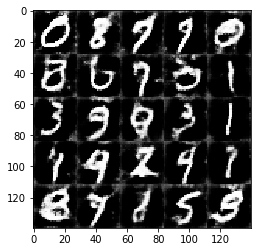

Epoch 1/2... Discriminator Loss: 1.0733... Generator Loss: 1.3437
Epoch 1/2... Discriminator Loss: 0.9468... Generator Loss: 0.9099
Epoch 1/2... Discriminator Loss: 1.0744... Generator Loss: 0.7437
Epoch 1/2... Discriminator Loss: 0.9299... Generator Loss: 0.9660
Epoch 1/2... Discriminator Loss: 1.0949... Generator Loss: 0.9088
Epoch 1/2... Discriminator Loss: 0.8630... Generator Loss: 1.6843
Epoch 1/2... Discriminator Loss: 1.2418... Generator Loss: 2.5284
Epoch 1/2... Discriminator Loss: 0.7738... Generator Loss: 1.2793
Epoch 1/2... Discriminator Loss: 2.6019... Generator Loss: 0.1486
Epoch 1/2... Discriminator Loss: 1.4476... Generator Loss: 0.4452


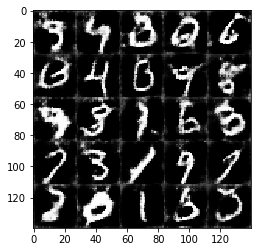

Epoch 1/2... Discriminator Loss: 1.6866... Generator Loss: 0.3545
Epoch 1/2... Discriminator Loss: 1.6959... Generator Loss: 0.4074
Epoch 1/2... Discriminator Loss: 0.9820... Generator Loss: 0.8634
Epoch 1/2... Discriminator Loss: 2.7026... Generator Loss: 0.1289
Epoch 1/2... Discriminator Loss: 2.1271... Generator Loss: 3.5524
Epoch 1/2... Discriminator Loss: 1.0109... Generator Loss: 0.8989
Epoch 1/2... Discriminator Loss: 1.0731... Generator Loss: 0.9198
Epoch 1/2... Discriminator Loss: 1.1783... Generator Loss: 0.5929
Epoch 1/2... Discriminator Loss: 1.2268... Generator Loss: 0.6159
Epoch 1/2... Discriminator Loss: 1.1910... Generator Loss: 0.9576


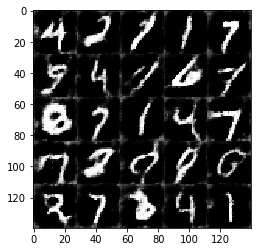

Epoch 1/2... Discriminator Loss: 1.4536... Generator Loss: 0.4358
Epoch 1/2... Discriminator Loss: 0.7978... Generator Loss: 1.2202
Epoch 1/2... Discriminator Loss: 1.6126... Generator Loss: 0.4180
Epoch 1/2... Discriminator Loss: 1.1425... Generator Loss: 2.5473
Epoch 1/2... Discriminator Loss: 0.8083... Generator Loss: 1.2889
Epoch 1/2... Discriminator Loss: 1.2413... Generator Loss: 1.6716
Epoch 1/2... Discriminator Loss: 0.9077... Generator Loss: 1.2500
Epoch 1/2... Discriminator Loss: 2.1195... Generator Loss: 0.2576
Epoch 1/2... Discriminator Loss: 1.0150... Generator Loss: 1.0838
Epoch 1/2... Discriminator Loss: 1.5818... Generator Loss: 1.6413


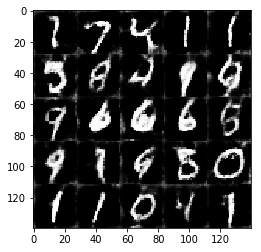

Epoch 1/2... Discriminator Loss: 1.4614... Generator Loss: 0.4225
Epoch 1/2... Discriminator Loss: 1.1031... Generator Loss: 0.8398
Epoch 1/2... Discriminator Loss: 0.7616... Generator Loss: 2.0055
Epoch 1/2... Discriminator Loss: 0.8778... Generator Loss: 1.7720
Epoch 1/2... Discriminator Loss: 1.6699... Generator Loss: 0.5227
Epoch 1/2... Discriminator Loss: 0.7809... Generator Loss: 1.4421
Epoch 1/2... Discriminator Loss: 0.9477... Generator Loss: 0.8991
Epoch 1/2... Discriminator Loss: 0.9291... Generator Loss: 0.9127
Epoch 1/2... Discriminator Loss: 1.3415... Generator Loss: 0.6440
Epoch 1/2... Discriminator Loss: 0.9824... Generator Loss: 0.8500


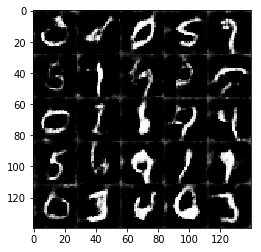

Epoch 1/2... Discriminator Loss: 1.7641... Generator Loss: 0.3035
Epoch 1/2... Discriminator Loss: 0.9495... Generator Loss: 1.2096
Epoch 1/2... Discriminator Loss: 1.1563... Generator Loss: 0.7826
Epoch 1/2... Discriminator Loss: 1.8472... Generator Loss: 3.5257
Epoch 1/2... Discriminator Loss: 1.0861... Generator Loss: 0.7648
Epoch 1/2... Discriminator Loss: 0.7517... Generator Loss: 1.7549
Epoch 1/2... Discriminator Loss: 0.8733... Generator Loss: 1.2345
Epoch 1/2... Discriminator Loss: 1.6425... Generator Loss: 0.3390
Epoch 2/2... Discriminator Loss: 0.8297... Generator Loss: 1.0142
Epoch 2/2... Discriminator Loss: 0.8584... Generator Loss: 1.6750


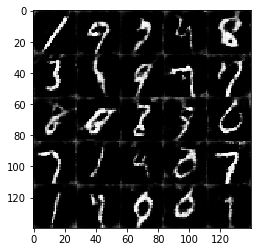

Epoch 2/2... Discriminator Loss: 0.9366... Generator Loss: 0.8877
Epoch 2/2... Discriminator Loss: 1.0843... Generator Loss: 0.7657
Epoch 2/2... Discriminator Loss: 0.6755... Generator Loss: 2.0291
Epoch 2/2... Discriminator Loss: 0.7471... Generator Loss: 1.6279
Epoch 2/2... Discriminator Loss: 1.0329... Generator Loss: 0.9372
Epoch 2/2... Discriminator Loss: 0.9976... Generator Loss: 1.2859
Epoch 2/2... Discriminator Loss: 0.7979... Generator Loss: 1.2731
Epoch 2/2... Discriminator Loss: 1.8083... Generator Loss: 0.3097
Epoch 2/2... Discriminator Loss: 1.0675... Generator Loss: 0.6954
Epoch 2/2... Discriminator Loss: 1.0481... Generator Loss: 2.8488


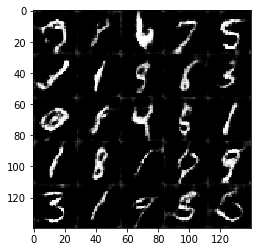

Epoch 2/2... Discriminator Loss: 0.6991... Generator Loss: 1.3983
Epoch 2/2... Discriminator Loss: 1.7808... Generator Loss: 0.3496
Epoch 2/2... Discriminator Loss: 1.4864... Generator Loss: 0.4458
Epoch 2/2... Discriminator Loss: 1.6233... Generator Loss: 4.2989
Epoch 2/2... Discriminator Loss: 0.6695... Generator Loss: 1.7567
Epoch 2/2... Discriminator Loss: 1.9174... Generator Loss: 0.2658
Epoch 2/2... Discriminator Loss: 1.4776... Generator Loss: 0.4234
Epoch 2/2... Discriminator Loss: 1.1678... Generator Loss: 0.7545
Epoch 2/2... Discriminator Loss: 0.9325... Generator Loss: 0.9801
Epoch 2/2... Discriminator Loss: 1.5264... Generator Loss: 0.5364


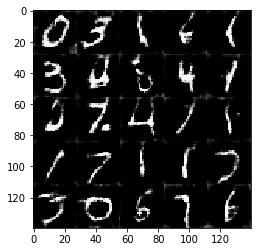

Epoch 2/2... Discriminator Loss: 1.8850... Generator Loss: 0.3972
Epoch 2/2... Discriminator Loss: 1.6861... Generator Loss: 0.3863
Epoch 2/2... Discriminator Loss: 1.7610... Generator Loss: 0.3059
Epoch 2/2... Discriminator Loss: 1.7286... Generator Loss: 0.3540
Epoch 2/2... Discriminator Loss: 2.3692... Generator Loss: 0.1793
Epoch 2/2... Discriminator Loss: 1.3415... Generator Loss: 0.5623
Epoch 2/2... Discriminator Loss: 1.4740... Generator Loss: 0.4794
Epoch 2/2... Discriminator Loss: 1.5712... Generator Loss: 0.4745
Epoch 2/2... Discriminator Loss: 1.3288... Generator Loss: 2.5088
Epoch 2/2... Discriminator Loss: 0.8245... Generator Loss: 1.7085


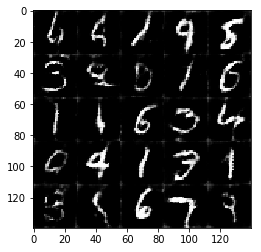

Epoch 2/2... Discriminator Loss: 1.8189... Generator Loss: 0.4273
Epoch 2/2... Discriminator Loss: 1.3139... Generator Loss: 0.6604
Epoch 2/2... Discriminator Loss: 2.4092... Generator Loss: 0.1715
Epoch 2/2... Discriminator Loss: 0.8363... Generator Loss: 1.5846
Epoch 2/2... Discriminator Loss: 1.2823... Generator Loss: 0.6008
Epoch 2/2... Discriminator Loss: 1.9524... Generator Loss: 0.3305
Epoch 2/2... Discriminator Loss: 1.4277... Generator Loss: 0.4499
Epoch 2/2... Discriminator Loss: 1.6573... Generator Loss: 0.4941
Epoch 2/2... Discriminator Loss: 1.5737... Generator Loss: 0.4602
Epoch 2/2... Discriminator Loss: 1.0270... Generator Loss: 1.0324


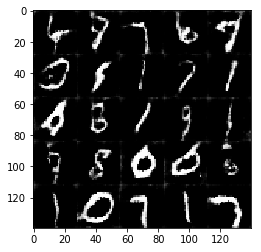

Epoch 2/2... Discriminator Loss: 2.5379... Generator Loss: 0.1347
Epoch 2/2... Discriminator Loss: 1.1961... Generator Loss: 0.6540
Epoch 2/2... Discriminator Loss: 0.9622... Generator Loss: 0.9504
Epoch 2/2... Discriminator Loss: 2.0664... Generator Loss: 0.2447
Epoch 2/2... Discriminator Loss: 0.8652... Generator Loss: 1.3694
Epoch 2/2... Discriminator Loss: 0.8908... Generator Loss: 2.0614
Epoch 2/2... Discriminator Loss: 1.3881... Generator Loss: 0.4652
Epoch 2/2... Discriminator Loss: 0.7434... Generator Loss: 1.6332
Epoch 2/2... Discriminator Loss: 1.6625... Generator Loss: 0.4053
Epoch 2/2... Discriminator Loss: 1.9295... Generator Loss: 0.2978


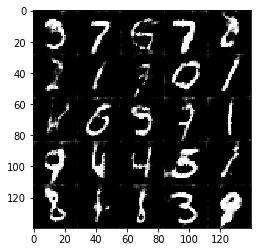

Epoch 2/2... Discriminator Loss: 1.4825... Generator Loss: 0.6217
Epoch 2/2... Discriminator Loss: 0.7727... Generator Loss: 1.1789
Epoch 2/2... Discriminator Loss: 1.0114... Generator Loss: 0.8542
Epoch 2/2... Discriminator Loss: 1.1300... Generator Loss: 0.6967
Epoch 2/2... Discriminator Loss: 2.0070... Generator Loss: 0.3017
Epoch 2/2... Discriminator Loss: 1.3492... Generator Loss: 0.6100
Epoch 2/2... Discriminator Loss: 2.6678... Generator Loss: 0.1849
Epoch 2/2... Discriminator Loss: 1.1915... Generator Loss: 0.7843
Epoch 2/2... Discriminator Loss: 1.7924... Generator Loss: 0.2741
Epoch 2/2... Discriminator Loss: 1.0034... Generator Loss: 0.9008


Epoch 2/2... Discriminator Loss: 2.2165... Generator Loss: 0.2562
Epoch 2/2... Discriminator Loss: 2.9043... Generator Loss: 0.1468
Epoch 2/2... Discriminator Loss: 0.8266... Generator Loss: 1.0953
Epoch 2/2... Discriminator Loss: 0.8160... Generator Loss: 1.1403
Epoch 2/2... Discriminator Loss: 1.0926... Generator Loss: 0.7531
Epoch 2/2... Discriminator Loss: 1.5889... Generator Loss: 0.4110
Epoch 2/2... Discriminator Loss: 1.0640... Generator Loss: 0.8899
Epoch 2/2... Discriminator Loss: 0.9550... Generator Loss: 1.0165
Epoch 2/2... Discriminator Loss: 1.6566... Generator Loss: 0.3641
Epoch 2/2... Discriminator Loss: 0.7452... Generator Loss: 1.2319


Epoch 2/2... Discriminator Loss: 0.9256... Generator Loss: 1.1233
Epoch 2/2... Discriminator Loss: 3.4467... Generator Loss: 0.0937
Epoch 2/2... Discriminator Loss: 1.6137... Generator Loss: 0.3441
Epoch 2/2... Discriminator Loss: 1.9601... Generator Loss: 0.2651
Epoch 2/2... Discriminator Loss: 1.1485... Generator Loss: 1.0349
Epoch 2/2... Discriminator Loss: 1.1256... Generator Loss: 0.8806
Epoch 2/2... Discriminator Loss: 1.3109... Generator Loss: 0.6879
Epoch 2/2... Discriminator Loss: 0.7491... Generator Loss: 1.3295
Epoch 2/2... Discriminator Loss: 1.3083... Generator Loss: 3.7815
Epoch 2/2... Discriminator Loss: 0.9655... Generator Loss: 0.9368


Epoch 2/2... Discriminator Loss: 1.3613... Generator Loss: 2.3769
Epoch 2/2... Discriminator Loss: 0.7470... Generator Loss: 1.4727
Epoch 2/2... Discriminator Loss: 1.0444... Generator Loss: 0.7592
Epoch 2/2... Discriminator Loss: 1.5707... Generator Loss: 0.3953
Epoch 2/2... Discriminator Loss: 1.0473... Generator Loss: 0.8092
Epoch 2/2... Discriminator Loss: 0.5778... Generator Loss: 2.4732
Epoch 2/2... Discriminator Loss: 0.8288... Generator Loss: 1.1441
Epoch 2/2... Discriminator Loss: 1.0813... Generator Loss: 0.9113
Epoch 2/2... Discriminator Loss: 0.6351... Generator Loss: 1.6083
Epoch 2/2... Discriminator Loss: 0.6158... Generator Loss: 1.5551


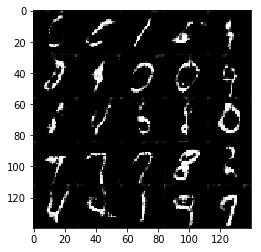

Epoch 2/2... Discriminator Loss: 1.8280... Generator Loss: 0.3227
Epoch 2/2... Discriminator Loss: 1.2802... Generator Loss: 0.5156
Epoch 2/2... Discriminator Loss: 1.1463... Generator Loss: 0.7540
Epoch 2/2... Discriminator Loss: 0.8314... Generator Loss: 1.0390
Epoch 2/2... Discriminator Loss: 1.0307... Generator Loss: 1.7105
Epoch 2/2... Discriminator Loss: 1.0517... Generator Loss: 1.3870
Epoch 2/2... Discriminator Loss: 2.0465... Generator Loss: 0.2475
Epoch 2/2... Discriminator Loss: 2.5116... Generator Loss: 0.1656
Epoch 2/2... Discriminator Loss: 0.7440... Generator Loss: 1.6753
Epoch 2/2... Discriminator Loss: 1.4918... Generator Loss: 0.4906


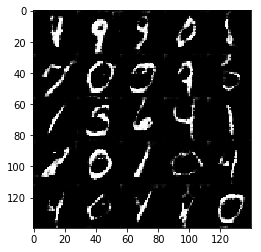

Epoch 2/2... Discriminator Loss: 1.2077... Generator Loss: 0.6609
Epoch 2/2... Discriminator Loss: 0.8227... Generator Loss: 1.1099
Epoch 2/2... Discriminator Loss: 0.9578... Generator Loss: 2.7383
Epoch 2/2... Discriminator Loss: 0.8361... Generator Loss: 1.2276
Epoch 2/2... Discriminator Loss: 1.2160... Generator Loss: 0.6522
Epoch 2/2... Discriminator Loss: 1.6379... Generator Loss: 0.3588
Epoch 2/2... Discriminator Loss: 0.9601... Generator Loss: 1.0898
Epoch 2/2... Discriminator Loss: 1.2226... Generator Loss: 0.6455
Epoch 2/2... Discriminator Loss: 1.5542... Generator Loss: 0.5118
Epoch 2/2... Discriminator Loss: 1.1201... Generator Loss: 0.7527


Epoch 2/2... Discriminator Loss: 1.3770... Generator Loss: 0.5614
Epoch 2/2... Discriminator Loss: 1.0812... Generator Loss: 0.7173
Epoch 2/2... Discriminator Loss: 1.3940... Generator Loss: 0.7195
Epoch 2/2... Discriminator Loss: 1.0047... Generator Loss: 0.8580
Epoch 2/2... Discriminator Loss: 1.6840... Generator Loss: 0.3356
Epoch 2/2... Discriminator Loss: 0.7070... Generator Loss: 1.2945
Epoch 2/2... Discriminator Loss: 1.1820... Generator Loss: 0.6020
Epoch 2/2... Discriminator Loss: 2.2369... Generator Loss: 0.1858
Epoch 2/2... Discriminator Loss: 1.4773... Generator Loss: 0.5906
Epoch 2/2... Discriminator Loss: 1.2981... Generator Loss: 0.5243


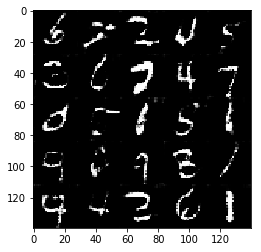

Epoch 2/2... Discriminator Loss: 0.9775... Generator Loss: 1.0082
Epoch 2/2... Discriminator Loss: 1.4376... Generator Loss: 0.7227
Epoch 2/2... Discriminator Loss: 2.1590... Generator Loss: 0.2833
Epoch 2/2... Discriminator Loss: 0.6947... Generator Loss: 2.2729
Epoch 2/2... Discriminator Loss: 0.6518... Generator Loss: 2.0978
Epoch 2/2... Discriminator Loss: 1.8044... Generator Loss: 0.2792
Epoch 2/2... Discriminator Loss: 0.7565... Generator Loss: 1.3633
Epoch 2/2... Discriminator Loss: 1.2466... Generator Loss: 1.8850
Epoch 2/2... Discriminator Loss: 0.9816... Generator Loss: 0.9653
Epoch 2/2... Discriminator Loss: 0.8854... Generator Loss: 1.0778


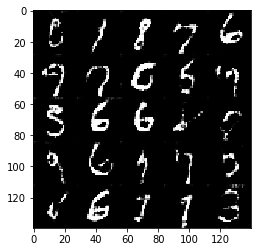

Epoch 2/2... Discriminator Loss: 0.7171... Generator Loss: 1.2687
Epoch 2/2... Discriminator Loss: 3.4404... Generator Loss: 0.0925
Epoch 2/2... Discriminator Loss: 1.7849... Generator Loss: 3.9640
Epoch 2/2... Discriminator Loss: 1.0012... Generator Loss: 0.8443
Epoch 2/2... Discriminator Loss: 1.4905... Generator Loss: 0.4675
Epoch 2/2... Discriminator Loss: 0.6666... Generator Loss: 1.3990
Epoch 2/2... Discriminator Loss: 1.2235... Generator Loss: 0.6075
Epoch 2/2... Discriminator Loss: 1.1293... Generator Loss: 0.7400
Epoch 2/2... Discriminator Loss: 1.1345... Generator Loss: 0.6470
Epoch 2/2... Discriminator Loss: 2.2637... Generator Loss: 0.1997


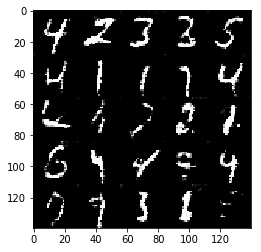

Epoch 2/2... Discriminator Loss: 1.4110... Generator Loss: 0.5376
Epoch 2/2... Discriminator Loss: 1.7696... Generator Loss: 0.3460
Epoch 2/2... Discriminator Loss: 0.6823... Generator Loss: 1.4795
Epoch 2/2... Discriminator Loss: 1.4470... Generator Loss: 0.5302
Epoch 2/2... Discriminator Loss: 0.8884... Generator Loss: 1.0588
Epoch 2/2... Discriminator Loss: 1.3301... Generator Loss: 0.5440
Epoch 2/2... Discriminator Loss: 1.1633... Generator Loss: 0.6381
Epoch 2/2... Discriminator Loss: 1.6413... Generator Loss: 0.4429
Epoch 2/2... Discriminator Loss: 1.2521... Generator Loss: 0.7046
Epoch 2/2... Discriminator Loss: 0.7289... Generator Loss: 1.2474


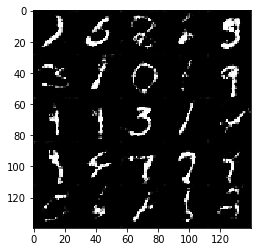

Epoch 2/2... Discriminator Loss: 1.1208... Generator Loss: 0.8796
Epoch 2/2... Discriminator Loss: 0.9337... Generator Loss: 0.9349
Epoch 2/2... Discriminator Loss: 1.8028... Generator Loss: 0.3011
Epoch 2/2... Discriminator Loss: 1.6265... Generator Loss: 0.4099
Epoch 2/2... Discriminator Loss: 1.1053... Generator Loss: 0.7772
Epoch 2/2... Discriminator Loss: 1.5007... Generator Loss: 0.5990
Epoch 2/2... Discriminator Loss: 0.8129... Generator Loss: 1.3044
Epoch 2/2... Discriminator Loss: 1.8597... Generator Loss: 0.3731
Epoch 2/2... Discriminator Loss: 2.4609... Generator Loss: 0.2240
Epoch 2/2... Discriminator Loss: 2.3826... Generator Loss: 0.2307


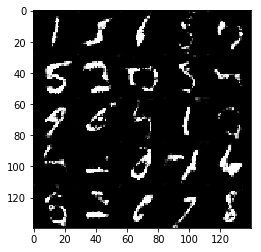

Epoch 2/2... Discriminator Loss: 0.9993... Generator Loss: 1.2174
Epoch 2/2... Discriminator Loss: 1.3743... Generator Loss: 0.5764
Epoch 2/2... Discriminator Loss: 1.4189... Generator Loss: 0.5018
Epoch 2/2... Discriminator Loss: 1.1968... Generator Loss: 0.6034
Epoch 2/2... Discriminator Loss: 0.6514... Generator Loss: 1.4327
Epoch 2/2... Discriminator Loss: 1.3250... Generator Loss: 0.5037
Epoch 2/2... Discriminator Loss: 1.3994... Generator Loss: 0.4545
Epoch 2/2... Discriminator Loss: 1.1490... Generator Loss: 0.6430
Epoch 2/2... Discriminator Loss: 1.0821... Generator Loss: 0.7779
Epoch 2/2... Discriminator Loss: 2.7241... Generator Loss: 0.1165


Epoch 2/2... Discriminator Loss: 0.7614... Generator Loss: 1.2899
Epoch 2/2... Discriminator Loss: 1.0250... Generator Loss: 0.9845
Epoch 2/2... Discriminator Loss: 0.7777... Generator Loss: 1.4521
Epoch 2/2... Discriminator Loss: 1.2886... Generator Loss: 0.6485
Epoch 2/2... Discriminator Loss: 1.6172... Generator Loss: 0.3921
Epoch 2/2... Discriminator Loss: 1.6087... Generator Loss: 0.4040
Epoch 2/2... Discriminator Loss: 0.9432... Generator Loss: 1.3027
Epoch 2/2... Discriminator Loss: 0.8542... Generator Loss: 1.1178
Epoch 2/2... Discriminator Loss: 1.9962... Generator Loss: 0.3506
Epoch 2/2... Discriminator Loss: 1.0661... Generator Loss: 0.7844


Epoch 2/2... Discriminator Loss: 0.7637... Generator Loss: 1.8473
Epoch 2/2... Discriminator Loss: 1.9556... Generator Loss: 0.2731
Epoch 2/2... Discriminator Loss: 3.2526... Generator Loss: 0.0954
Epoch 2/2... Discriminator Loss: 1.2498... Generator Loss: 0.5847
Epoch 2/2... Discriminator Loss: 0.8886... Generator Loss: 1.1843
Epoch 2/2... Discriminator Loss: 0.9537... Generator Loss: 0.9620


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.1625... Generator Loss: 0.0496
Epoch 1/1... Discriminator Loss: 9.0328... Generator Loss: 0.0004
Epoch 1/1... Discriminator Loss: 6.8627... Generator Loss: 0.0030
Epoch 1/1... Discriminator Loss: 8.3492... Generator Loss: 0.0008
Epoch 1/1... Discriminator Loss: 3.9973... Generator Loss: 0.0873
Epoch 1/1... Discriminator Loss: 0.8108... Generator Loss: 4.4727
Epoch 1/1... Discriminator Loss: 4.5758... Generator Loss: 0.0448
Epoch 1/1... Discriminator Loss: 4.6815... Generator Loss: 0.0164
Epoch 1/1... Discriminator Loss: 3.5816... Generator Loss: 0.0742


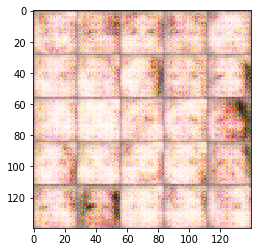

Epoch 1/1... Discriminator Loss: 0.9750... Generator Loss: 1.4294
Epoch 1/1... Discriminator Loss: 1.5042... Generator Loss: 0.8606
Epoch 1/1... Discriminator Loss: 0.5894... Generator Loss: 5.2537
Epoch 1/1... Discriminator Loss: 3.7058... Generator Loss: 0.0595
Epoch 1/1... Discriminator Loss: 2.8802... Generator Loss: 0.1124
Epoch 1/1... Discriminator Loss: 0.6895... Generator Loss: 2.3498
Epoch 1/1... Discriminator Loss: 0.6137... Generator Loss: 2.0217
Epoch 1/1... Discriminator Loss: 0.7476... Generator Loss: 2.7834
Epoch 1/1... Discriminator Loss: 0.7108... Generator Loss: 1.5905
Epoch 1/1... Discriminator Loss: 0.7543... Generator Loss: 1.7529


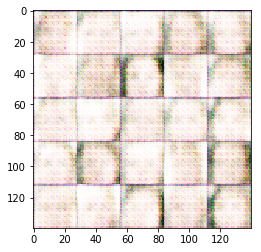

Epoch 1/1... Discriminator Loss: 2.5365... Generator Loss: 0.2246
Epoch 1/1... Discriminator Loss: 1.4449... Generator Loss: 8.0941
Epoch 1/1... Discriminator Loss: 0.5687... Generator Loss: 1.8662
Epoch 1/1... Discriminator Loss: 0.6661... Generator Loss: 1.6558
Epoch 1/1... Discriminator Loss: 1.5693... Generator Loss: 2.3029
Epoch 1/1... Discriminator Loss: 1.5483... Generator Loss: 2.8243
Epoch 1/1... Discriminator Loss: 0.6282... Generator Loss: 1.7374
Epoch 1/1... Discriminator Loss: 0.9624... Generator Loss: 3.7350
Epoch 1/1... Discriminator Loss: 0.5040... Generator Loss: 2.1475
Epoch 1/1... Discriminator Loss: 0.8615... Generator Loss: 2.2809


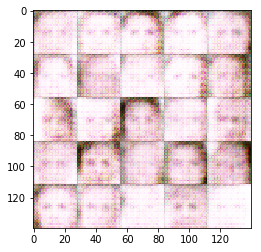

Epoch 1/1... Discriminator Loss: 0.9083... Generator Loss: 1.4897
Epoch 1/1... Discriminator Loss: 2.6625... Generator Loss: 0.1393
Epoch 1/1... Discriminator Loss: 0.9585... Generator Loss: 1.0006
Epoch 1/1... Discriminator Loss: 1.6564... Generator Loss: 0.4395
Epoch 1/1... Discriminator Loss: 0.5615... Generator Loss: 2.3754
Epoch 1/1... Discriminator Loss: 0.7161... Generator Loss: 1.4668
Epoch 1/1... Discriminator Loss: 0.9356... Generator Loss: 1.0617
Epoch 1/1... Discriminator Loss: 1.5777... Generator Loss: 0.4917
Epoch 1/1... Discriminator Loss: 1.2100... Generator Loss: 0.7041
Epoch 1/1... Discriminator Loss: 0.7875... Generator Loss: 1.3907


Epoch 1/1... Discriminator Loss: 0.5117... Generator Loss: 4.5132
Epoch 1/1... Discriminator Loss: 1.1741... Generator Loss: 0.8046
Epoch 1/1... Discriminator Loss: 1.0226... Generator Loss: 1.3207
Epoch 1/1... Discriminator Loss: 1.1506... Generator Loss: 0.9880
Epoch 1/1... Discriminator Loss: 1.5328... Generator Loss: 0.4750
Epoch 1/1... Discriminator Loss: 1.9263... Generator Loss: 0.3400
Epoch 1/1... Discriminator Loss: 2.8551... Generator Loss: 0.1225
Epoch 1/1... Discriminator Loss: 0.4142... Generator Loss: 3.6067
Epoch 1/1... Discriminator Loss: 1.9750... Generator Loss: 3.0963
Epoch 1/1... Discriminator Loss: 1.6424... Generator Loss: 0.3437


Epoch 1/1... Discriminator Loss: 0.9582... Generator Loss: 0.9743
Epoch 1/1... Discriminator Loss: 0.8749... Generator Loss: 1.1417
Epoch 1/1... Discriminator Loss: 0.3588... Generator Loss: 5.5615
Epoch 1/1... Discriminator Loss: 0.6143... Generator Loss: 3.5375
Epoch 1/1... Discriminator Loss: 1.7192... Generator Loss: 5.3374
Epoch 1/1... Discriminator Loss: 0.4098... Generator Loss: 5.6536
Epoch 1/1... Discriminator Loss: 0.8797... Generator Loss: 1.1924
Epoch 1/1... Discriminator Loss: 1.0567... Generator Loss: 1.4942
Epoch 1/1... Discriminator Loss: 0.4002... Generator Loss: 3.3528
Epoch 1/1... Discriminator Loss: 2.4589... Generator Loss: 9.2615


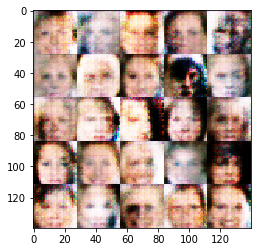

Epoch 1/1... Discriminator Loss: 0.7629... Generator Loss: 1.0989
Epoch 1/1... Discriminator Loss: 1.7064... Generator Loss: 0.5134
Epoch 1/1... Discriminator Loss: 0.9851... Generator Loss: 1.0161
Epoch 1/1... Discriminator Loss: 2.1431... Generator Loss: 3.3620
Epoch 1/1... Discriminator Loss: 0.9423... Generator Loss: 4.4992
Epoch 1/1... Discriminator Loss: 1.0676... Generator Loss: 0.9676
Epoch 1/1... Discriminator Loss: 0.4366... Generator Loss: 3.6987
Epoch 1/1... Discriminator Loss: 0.3938... Generator Loss: 4.0806
Epoch 1/1... Discriminator Loss: 3.1540... Generator Loss: 0.0743
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.6206


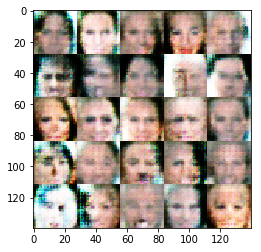

Epoch 1/1... Discriminator Loss: 0.4063... Generator Loss: 3.4289
Epoch 1/1... Discriminator Loss: 2.8788... Generator Loss: 0.1280
Epoch 1/1... Discriminator Loss: 0.7912... Generator Loss: 1.1618
Epoch 1/1... Discriminator Loss: 0.4246... Generator Loss: 3.3625
Epoch 1/1... Discriminator Loss: 0.8896... Generator Loss: 1.1677
Epoch 1/1... Discriminator Loss: 0.6312... Generator Loss: 2.2751
Epoch 1/1... Discriminator Loss: 1.0053... Generator Loss: 0.9192
Epoch 1/1... Discriminator Loss: 0.6960... Generator Loss: 1.3811
Epoch 1/1... Discriminator Loss: 2.7148... Generator Loss: 0.1112
Epoch 1/1... Discriminator Loss: 1.2856... Generator Loss: 1.0940


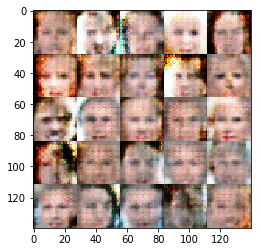

Epoch 1/1... Discriminator Loss: 1.0551... Generator Loss: 1.3544
Epoch 1/1... Discriminator Loss: 1.1370... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 1.2549... Generator Loss: 0.6104
Epoch 1/1... Discriminator Loss: 1.2868... Generator Loss: 0.5787
Epoch 1/1... Discriminator Loss: 0.8052... Generator Loss: 1.2161
Epoch 1/1... Discriminator Loss: 0.9943... Generator Loss: 0.9468
Epoch 1/1... Discriminator Loss: 1.3200... Generator Loss: 0.8149
Epoch 1/1... Discriminator Loss: 0.6424... Generator Loss: 2.4860
Epoch 1/1... Discriminator Loss: 1.5393... Generator Loss: 0.3962
Epoch 1/1... Discriminator Loss: 1.6060... Generator Loss: 0.3765


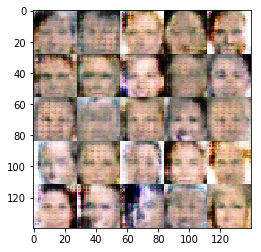

Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.5471
Epoch 1/1... Discriminator Loss: 2.4228... Generator Loss: 0.1362
Epoch 1/1... Discriminator Loss: 0.4719... Generator Loss: 2.8642
Epoch 1/1... Discriminator Loss: 0.9209... Generator Loss: 1.8796
Epoch 1/1... Discriminator Loss: 0.9595... Generator Loss: 0.9477
Epoch 1/1... Discriminator Loss: 1.7073... Generator Loss: 0.3462
Epoch 1/1... Discriminator Loss: 0.6398... Generator Loss: 1.4705
Epoch 1/1... Discriminator Loss: 0.7105... Generator Loss: 1.3754
Epoch 1/1... Discriminator Loss: 1.1232... Generator Loss: 2.9723
Epoch 1/1... Discriminator Loss: 0.6878... Generator Loss: 1.6001


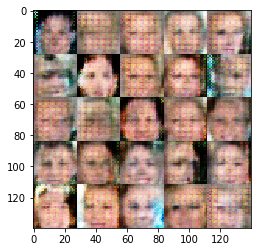

Epoch 1/1... Discriminator Loss: 2.0897... Generator Loss: 0.2128
Epoch 1/1... Discriminator Loss: 0.6881... Generator Loss: 1.9298
Epoch 1/1... Discriminator Loss: 2.8831... Generator Loss: 0.1069
Epoch 1/1... Discriminator Loss: 0.9733... Generator Loss: 1.4033
Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 0.6283
Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.4582
Epoch 1/1... Discriminator Loss: 0.5661... Generator Loss: 1.8123
Epoch 1/1... Discriminator Loss: 1.5789... Generator Loss: 0.3652
Epoch 1/1... Discriminator Loss: 0.7754... Generator Loss: 1.1624
Epoch 1/1... Discriminator Loss: 0.5813... Generator Loss: 2.3229


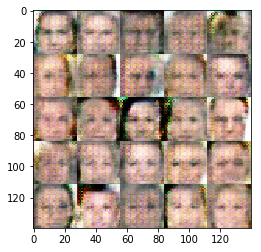

Epoch 1/1... Discriminator Loss: 1.5300... Generator Loss: 0.5874
Epoch 1/1... Discriminator Loss: 0.6959... Generator Loss: 1.3907
Epoch 1/1... Discriminator Loss: 1.5755... Generator Loss: 0.4330
Epoch 1/1... Discriminator Loss: 0.9093... Generator Loss: 1.0756
Epoch 1/1... Discriminator Loss: 1.2163... Generator Loss: 0.8999
Epoch 1/1... Discriminator Loss: 1.8555... Generator Loss: 0.3161
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.4569
Epoch 1/1... Discriminator Loss: 1.5798... Generator Loss: 0.3766
Epoch 1/1... Discriminator Loss: 1.5268... Generator Loss: 0.3918
Epoch 1/1... Discriminator Loss: 1.8947... Generator Loss: 0.2658


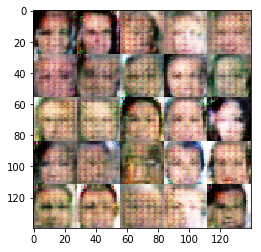

Epoch 1/1... Discriminator Loss: 1.2731... Generator Loss: 1.1294
Epoch 1/1... Discriminator Loss: 1.6403... Generator Loss: 1.7993
Epoch 1/1... Discriminator Loss: 1.4939... Generator Loss: 0.4745
Epoch 1/1... Discriminator Loss: 0.9937... Generator Loss: 0.7857
Epoch 1/1... Discriminator Loss: 0.6777... Generator Loss: 1.5433
Epoch 1/1... Discriminator Loss: 1.1859... Generator Loss: 0.5891
Epoch 1/1... Discriminator Loss: 0.5277... Generator Loss: 1.8892
Epoch 1/1... Discriminator Loss: 1.5129... Generator Loss: 3.7819
Epoch 1/1... Discriminator Loss: 0.9401... Generator Loss: 0.8542
Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.4704


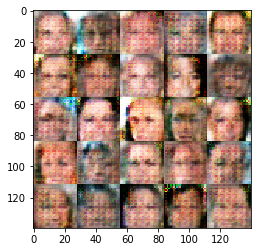

Epoch 1/1... Discriminator Loss: 1.4677... Generator Loss: 0.4353
Epoch 1/1... Discriminator Loss: 1.1728... Generator Loss: 1.9592
Epoch 1/1... Discriminator Loss: 0.7158... Generator Loss: 1.6213
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.4722
Epoch 1/1... Discriminator Loss: 0.9779... Generator Loss: 2.9616
Epoch 1/1... Discriminator Loss: 1.5100... Generator Loss: 0.4532
Epoch 1/1... Discriminator Loss: 1.0475... Generator Loss: 0.8402
Epoch 1/1... Discriminator Loss: 1.8677... Generator Loss: 0.2920
Epoch 1/1... Discriminator Loss: 0.7599... Generator Loss: 1.2792
Epoch 1/1... Discriminator Loss: 1.6732... Generator Loss: 2.3686


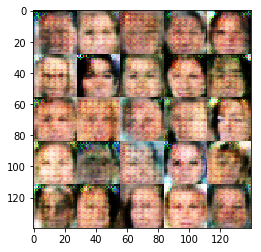

Epoch 1/1... Discriminator Loss: 1.0425... Generator Loss: 0.7420
Epoch 1/1... Discriminator Loss: 1.2271... Generator Loss: 1.0956
Epoch 1/1... Discriminator Loss: 1.4819... Generator Loss: 0.5230
Epoch 1/1... Discriminator Loss: 1.1090... Generator Loss: 1.0549
Epoch 1/1... Discriminator Loss: 0.9996... Generator Loss: 0.8549
Epoch 1/1... Discriminator Loss: 0.5921... Generator Loss: 1.6869
Epoch 1/1... Discriminator Loss: 0.6408... Generator Loss: 1.4761
Epoch 1/1... Discriminator Loss: 0.5567... Generator Loss: 2.9621
Epoch 1/1... Discriminator Loss: 1.3498... Generator Loss: 0.6136
Epoch 1/1... Discriminator Loss: 1.1491... Generator Loss: 1.1549


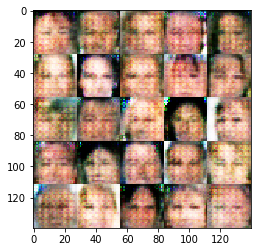

Epoch 1/1... Discriminator Loss: 1.1354... Generator Loss: 0.6908
Epoch 1/1... Discriminator Loss: 0.8666... Generator Loss: 1.1439
Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.4912
Epoch 1/1... Discriminator Loss: 0.4782... Generator Loss: 2.4639
Epoch 1/1... Discriminator Loss: 0.3585... Generator Loss: 3.9928
Epoch 1/1... Discriminator Loss: 0.5129... Generator Loss: 2.0487
Epoch 1/1... Discriminator Loss: 0.6612... Generator Loss: 1.6008
Epoch 1/1... Discriminator Loss: 2.3353... Generator Loss: 0.1609
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.5168
Epoch 1/1... Discriminator Loss: 0.6431... Generator Loss: 1.5158


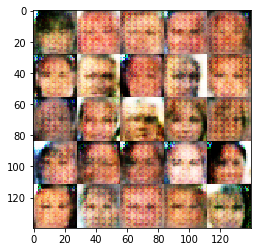

Epoch 1/1... Discriminator Loss: 1.1998... Generator Loss: 0.9944
Epoch 1/1... Discriminator Loss: 0.4495... Generator Loss: 2.6501
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.5017
Epoch 1/1... Discriminator Loss: 1.2472... Generator Loss: 0.6056
Epoch 1/1... Discriminator Loss: 0.7476... Generator Loss: 1.3874
Epoch 1/1... Discriminator Loss: 0.5872... Generator Loss: 1.9367
Epoch 1/1... Discriminator Loss: 1.7021... Generator Loss: 2.5636
Epoch 1/1... Discriminator Loss: 0.8077... Generator Loss: 2.8917
Epoch 1/1... Discriminator Loss: 1.0264... Generator Loss: 0.8315
Epoch 1/1... Discriminator Loss: 0.7505... Generator Loss: 1.7011


Epoch 1/1... Discriminator Loss: 0.9314... Generator Loss: 1.0321
Epoch 1/1... Discriminator Loss: 0.5819... Generator Loss: 2.8770
Epoch 1/1... Discriminator Loss: 1.7235... Generator Loss: 0.3294
Epoch 1/1... Discriminator Loss: 1.1593... Generator Loss: 0.6429
Epoch 1/1... Discriminator Loss: 1.1848... Generator Loss: 0.6109
Epoch 1/1... Discriminator Loss: 1.0477... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.5123... Generator Loss: 0.5037
Epoch 1/1... Discriminator Loss: 1.1823... Generator Loss: 1.3003
Epoch 1/1... Discriminator Loss: 1.5177... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 0.9762... Generator Loss: 1.2228


Epoch 1/1... Discriminator Loss: 0.9377... Generator Loss: 1.3483
Epoch 1/1... Discriminator Loss: 1.7289... Generator Loss: 0.2937
Epoch 1/1... Discriminator Loss: 0.8863... Generator Loss: 0.9335
Epoch 1/1... Discriminator Loss: 1.5518... Generator Loss: 0.4712
Epoch 1/1... Discriminator Loss: 3.3402... Generator Loss: 0.0794
Epoch 1/1... Discriminator Loss: 1.5113... Generator Loss: 0.4249
Epoch 1/1... Discriminator Loss: 1.3006... Generator Loss: 0.5684
Epoch 1/1... Discriminator Loss: 0.7775... Generator Loss: 1.4492
Epoch 1/1... Discriminator Loss: 2.6568... Generator Loss: 0.1250
Epoch 1/1... Discriminator Loss: 0.7270... Generator Loss: 1.3085


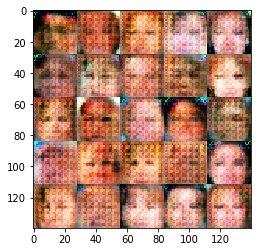

Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 1.2176
Epoch 1/1... Discriminator Loss: 1.3517... Generator Loss: 0.7738
Epoch 1/1... Discriminator Loss: 1.2776... Generator Loss: 0.6393
Epoch 1/1... Discriminator Loss: 1.1099... Generator Loss: 0.6904
Epoch 1/1... Discriminator Loss: 0.4671... Generator Loss: 2.1486
Epoch 1/1... Discriminator Loss: 0.4743... Generator Loss: 2.0809
Epoch 1/1... Discriminator Loss: 0.9429... Generator Loss: 0.8836
Epoch 1/1... Discriminator Loss: 1.1883... Generator Loss: 1.6829
Epoch 1/1... Discriminator Loss: 0.9609... Generator Loss: 0.8849
Epoch 1/1... Discriminator Loss: 2.2497... Generator Loss: 2.5816


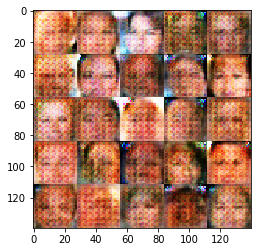

Epoch 1/1... Discriminator Loss: 0.9830... Generator Loss: 1.2713
Epoch 1/1... Discriminator Loss: 0.7437... Generator Loss: 1.4400
Epoch 1/1... Discriminator Loss: 0.6137... Generator Loss: 1.5783
Epoch 1/1... Discriminator Loss: 0.9348... Generator Loss: 0.8998
Epoch 1/1... Discriminator Loss: 0.5148... Generator Loss: 2.2199
Epoch 1/1... Discriminator Loss: 1.2449... Generator Loss: 0.7131
Epoch 1/1... Discriminator Loss: 1.0648... Generator Loss: 1.4705
Epoch 1/1... Discriminator Loss: 0.8430... Generator Loss: 1.1826
Epoch 1/1... Discriminator Loss: 2.3532... Generator Loss: 0.1874
Epoch 1/1... Discriminator Loss: 0.7129... Generator Loss: 1.3639


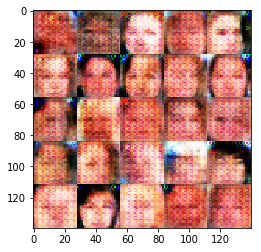

Epoch 1/1... Discriminator Loss: 0.9109... Generator Loss: 1.0123
Epoch 1/1... Discriminator Loss: 0.4492... Generator Loss: 2.3080
Epoch 1/1... Discriminator Loss: 1.7016... Generator Loss: 1.8287
Epoch 1/1... Discriminator Loss: 0.7469... Generator Loss: 1.5675
Epoch 1/1... Discriminator Loss: 1.0984... Generator Loss: 1.2515
Epoch 1/1... Discriminator Loss: 0.5753... Generator Loss: 2.1771
Epoch 1/1... Discriminator Loss: 0.5233... Generator Loss: 2.4061
Epoch 1/1... Discriminator Loss: 1.5575... Generator Loss: 0.3558
Epoch 1/1... Discriminator Loss: 0.4901... Generator Loss: 2.5766
Epoch 1/1... Discriminator Loss: 2.4533... Generator Loss: 4.7538


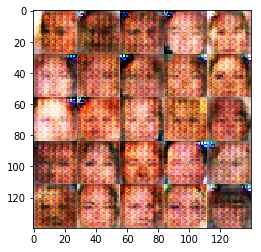

Epoch 1/1... Discriminator Loss: 0.3796... Generator Loss: 4.8315
Epoch 1/1... Discriminator Loss: 1.8656... Generator Loss: 0.2555
Epoch 1/1... Discriminator Loss: 0.7958... Generator Loss: 1.4925
Epoch 1/1... Discriminator Loss: 0.7451... Generator Loss: 1.2473
Epoch 1/1... Discriminator Loss: 0.5804... Generator Loss: 2.6788
Epoch 1/1... Discriminator Loss: 2.1819... Generator Loss: 3.5073
Epoch 1/1... Discriminator Loss: 1.2069... Generator Loss: 0.6097
Epoch 1/1... Discriminator Loss: 0.5263... Generator Loss: 1.8870
Epoch 1/1... Discriminator Loss: 1.2921... Generator Loss: 0.5252
Epoch 1/1... Discriminator Loss: 0.7116... Generator Loss: 1.8102


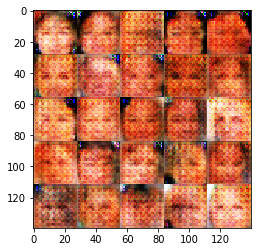

Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 0.4559
Epoch 1/1... Discriminator Loss: 0.9730... Generator Loss: 0.8612
Epoch 1/1... Discriminator Loss: 0.5969... Generator Loss: 2.6453
Epoch 1/1... Discriminator Loss: 0.9769... Generator Loss: 1.0386
Epoch 1/1... Discriminator Loss: 2.0499... Generator Loss: 0.2166
Epoch 1/1... Discriminator Loss: 1.2766... Generator Loss: 0.6071
Epoch 1/1... Discriminator Loss: 0.3575... Generator Loss: 4.9813
Epoch 1/1... Discriminator Loss: 0.8312... Generator Loss: 1.2173
Epoch 1/1... Discriminator Loss: 1.0228... Generator Loss: 0.9958
Epoch 1/1... Discriminator Loss: 1.1038... Generator Loss: 0.6647


Epoch 1/1... Discriminator Loss: 1.6387... Generator Loss: 0.3368
Epoch 1/1... Discriminator Loss: 1.0117... Generator Loss: 0.7484
Epoch 1/1... Discriminator Loss: 0.9332... Generator Loss: 0.8973
Epoch 1/1... Discriminator Loss: 2.6554... Generator Loss: 0.1343
Epoch 1/1... Discriminator Loss: 0.9919... Generator Loss: 0.7938
Epoch 1/1... Discriminator Loss: 1.0477... Generator Loss: 1.3469
Epoch 1/1... Discriminator Loss: 1.8162... Generator Loss: 0.3339
Epoch 1/1... Discriminator Loss: 0.5305... Generator Loss: 2.4618
Epoch 1/1... Discriminator Loss: 1.0746... Generator Loss: 0.6764
Epoch 1/1... Discriminator Loss: 0.9857... Generator Loss: 1.1251


Epoch 1/1... Discriminator Loss: 1.0568... Generator Loss: 0.7615
Epoch 1/1... Discriminator Loss: 1.9103... Generator Loss: 0.2622
Epoch 1/1... Discriminator Loss: 1.0795... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 0.6001... Generator Loss: 1.7249
Epoch 1/1... Discriminator Loss: 0.8545... Generator Loss: 3.9668
Epoch 1/1... Discriminator Loss: 1.9113... Generator Loss: 0.2679
Epoch 1/1... Discriminator Loss: 0.5729... Generator Loss: 1.8175
Epoch 1/1... Discriminator Loss: 0.5340... Generator Loss: 1.9071
Epoch 1/1... Discriminator Loss: 1.1942... Generator Loss: 0.5881
Epoch 1/1... Discriminator Loss: 0.6070... Generator Loss: 2.2974


Epoch 1/1... Discriminator Loss: 0.6917... Generator Loss: 1.2477
Epoch 1/1... Discriminator Loss: 0.3819... Generator Loss: 3.1141
Epoch 1/1... Discriminator Loss: 1.0717... Generator Loss: 2.2129
Epoch 1/1... Discriminator Loss: 0.6200... Generator Loss: 1.6508
Epoch 1/1... Discriminator Loss: 0.3774... Generator Loss: 3.2267
Epoch 1/1... Discriminator Loss: 1.1199... Generator Loss: 0.6409
Epoch 1/1... Discriminator Loss: 0.5620... Generator Loss: 1.6428
Epoch 1/1... Discriminator Loss: 1.4918... Generator Loss: 0.6338
Epoch 1/1... Discriminator Loss: 2.9630... Generator Loss: 3.6784
Epoch 1/1... Discriminator Loss: 0.4093... Generator Loss: 2.8351


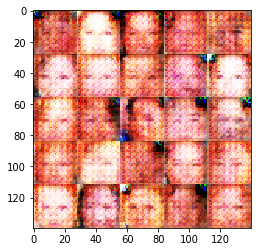

Epoch 1/1... Discriminator Loss: 1.5867... Generator Loss: 2.3058
Epoch 1/1... Discriminator Loss: 1.2913... Generator Loss: 0.6442
Epoch 1/1... Discriminator Loss: 0.8042... Generator Loss: 1.1716
Epoch 1/1... Discriminator Loss: 0.6722... Generator Loss: 1.3798
Epoch 1/1... Discriminator Loss: 0.4640... Generator Loss: 5.3088
Epoch 1/1... Discriminator Loss: 0.9754... Generator Loss: 1.8238
Epoch 1/1... Discriminator Loss: 0.4666... Generator Loss: 2.5139
Epoch 1/1... Discriminator Loss: 1.5407... Generator Loss: 0.3788
Epoch 1/1... Discriminator Loss: 0.7247... Generator Loss: 1.1745
Epoch 1/1... Discriminator Loss: 0.8443... Generator Loss: 1.5943


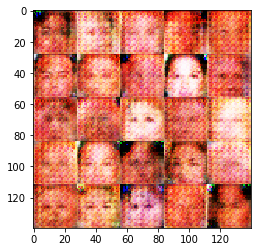

Epoch 1/1... Discriminator Loss: 0.4778... Generator Loss: 2.7262
Epoch 1/1... Discriminator Loss: 1.2948... Generator Loss: 0.5595
Epoch 1/1... Discriminator Loss: 1.4367... Generator Loss: 0.5145
Epoch 1/1... Discriminator Loss: 1.0845... Generator Loss: 0.8247
Epoch 1/1... Discriminator Loss: 1.0616... Generator Loss: 0.7082
Epoch 1/1... Discriminator Loss: 1.0260... Generator Loss: 0.7674
Epoch 1/1... Discriminator Loss: 1.4945... Generator Loss: 0.4058
Epoch 1/1... Discriminator Loss: 0.3806... Generator Loss: 3.9399
Epoch 1/1... Discriminator Loss: 1.2163... Generator Loss: 0.8114
Epoch 1/1... Discriminator Loss: 1.1160... Generator Loss: 0.7530


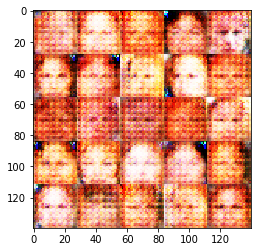

Epoch 1/1... Discriminator Loss: 1.7546... Generator Loss: 0.2979
Epoch 1/1... Discriminator Loss: 1.0045... Generator Loss: 0.9032
Epoch 1/1... Discriminator Loss: 1.0406... Generator Loss: 0.8663
Epoch 1/1... Discriminator Loss: 0.7581... Generator Loss: 2.3796
Epoch 1/1... Discriminator Loss: 1.5191... Generator Loss: 0.4297
Epoch 1/1... Discriminator Loss: 2.2851... Generator Loss: 2.1352
Epoch 1/1... Discriminator Loss: 2.8768... Generator Loss: 0.1182
Epoch 1/1... Discriminator Loss: 1.1614... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 1.2918... Generator Loss: 0.5995
Epoch 1/1... Discriminator Loss: 1.3110... Generator Loss: 0.8047


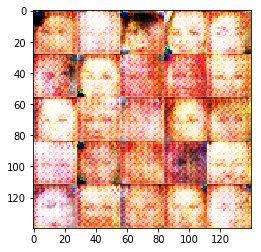

Epoch 1/1... Discriminator Loss: 1.8470... Generator Loss: 0.2598
Epoch 1/1... Discriminator Loss: 0.8245... Generator Loss: 1.0348
Epoch 1/1... Discriminator Loss: 1.0873... Generator Loss: 0.6632
Epoch 1/1... Discriminator Loss: 0.8573... Generator Loss: 1.0064
Epoch 1/1... Discriminator Loss: 0.5777... Generator Loss: 2.2872
Epoch 1/1... Discriminator Loss: 1.2277... Generator Loss: 1.3864
Epoch 1/1... Discriminator Loss: 1.6958... Generator Loss: 0.3249
Epoch 1/1... Discriminator Loss: 0.9163... Generator Loss: 1.1304
Epoch 1/1... Discriminator Loss: 2.0367... Generator Loss: 0.2170
Epoch 1/1... Discriminator Loss: 0.7089... Generator Loss: 1.6809


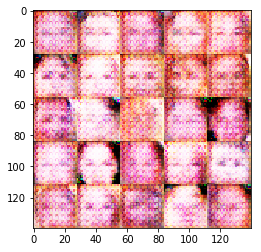

Epoch 1/1... Discriminator Loss: 0.9918... Generator Loss: 1.7732
Epoch 1/1... Discriminator Loss: 0.6156... Generator Loss: 2.2311
Epoch 1/1... Discriminator Loss: 0.6536... Generator Loss: 3.8498
Epoch 1/1... Discriminator Loss: 1.1632... Generator Loss: 1.0982
Epoch 1/1... Discriminator Loss: 0.7704... Generator Loss: 1.1947
Epoch 1/1... Discriminator Loss: 2.1326... Generator Loss: 0.2061
Epoch 1/1... Discriminator Loss: 1.9215... Generator Loss: 0.2506
Epoch 1/1... Discriminator Loss: 0.7127... Generator Loss: 1.6493
Epoch 1/1... Discriminator Loss: 0.4223... Generator Loss: 2.8270
Epoch 1/1... Discriminator Loss: 2.6769... Generator Loss: 0.1231


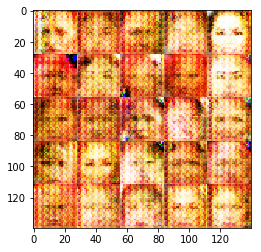

Epoch 1/1... Discriminator Loss: 1.1079... Generator Loss: 0.9553
Epoch 1/1... Discriminator Loss: 1.0975... Generator Loss: 0.6759
Epoch 1/1... Discriminator Loss: 1.2893... Generator Loss: 0.6530
Epoch 1/1... Discriminator Loss: 2.8207... Generator Loss: 0.1204
Epoch 1/1... Discriminator Loss: 1.0378... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 0.9541... Generator Loss: 2.5255
Epoch 1/1... Discriminator Loss: 1.1686... Generator Loss: 0.6770
Epoch 1/1... Discriminator Loss: 1.1981... Generator Loss: 0.7201
Epoch 1/1... Discriminator Loss: 1.1163... Generator Loss: 0.6474
Epoch 1/1... Discriminator Loss: 0.8586... Generator Loss: 3.0932


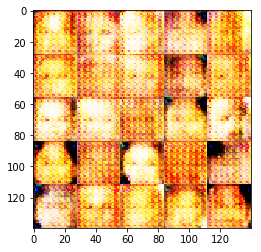

Epoch 1/1... Discriminator Loss: 1.8357... Generator Loss: 0.3406
Epoch 1/1... Discriminator Loss: 3.2634... Generator Loss: 4.8820
Epoch 1/1... Discriminator Loss: 0.5580... Generator Loss: 3.1761
Epoch 1/1... Discriminator Loss: 2.0268... Generator Loss: 0.2202
Epoch 1/1... Discriminator Loss: 0.4453... Generator Loss: 3.2085
Epoch 1/1... Discriminator Loss: 0.8206... Generator Loss: 1.3324
Epoch 1/1... Discriminator Loss: 1.0160... Generator Loss: 2.4330
Epoch 1/1... Discriminator Loss: 2.3135... Generator Loss: 0.1649
Epoch 1/1... Discriminator Loss: 1.0141... Generator Loss: 0.8101
Epoch 1/1... Discriminator Loss: 0.8278... Generator Loss: 1.1986


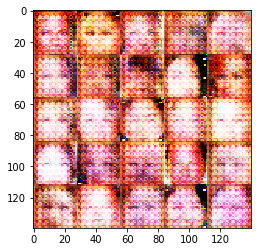

Epoch 1/1... Discriminator Loss: 0.4895... Generator Loss: 3.6344
Epoch 1/1... Discriminator Loss: 1.1833... Generator Loss: 0.6611
Epoch 1/1... Discriminator Loss: 0.8251... Generator Loss: 2.1958
Epoch 1/1... Discriminator Loss: 0.7164... Generator Loss: 1.2414
Epoch 1/1... Discriminator Loss: 1.2256... Generator Loss: 1.1866
Epoch 1/1... Discriminator Loss: 0.8892... Generator Loss: 1.0735
Epoch 1/1... Discriminator Loss: 1.7955... Generator Loss: 0.3261
Epoch 1/1... Discriminator Loss: 0.9889... Generator Loss: 0.9636
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.5785
Epoch 1/1... Discriminator Loss: 0.7533... Generator Loss: 2.4003


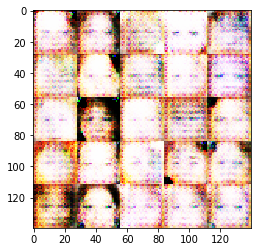

Epoch 1/1... Discriminator Loss: 1.7098... Generator Loss: 0.3658
Epoch 1/1... Discriminator Loss: 0.9992... Generator Loss: 0.8228
Epoch 1/1... Discriminator Loss: 2.1922... Generator Loss: 0.1973
Epoch 1/1... Discriminator Loss: 0.8431... Generator Loss: 0.9539
Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 0.5087
Epoch 1/1... Discriminator Loss: 1.1319... Generator Loss: 1.7196
Epoch 1/1... Discriminator Loss: 0.3957... Generator Loss: 2.9405
Epoch 1/1... Discriminator Loss: 0.4526... Generator Loss: 2.3218
Epoch 1/1... Discriminator Loss: 1.2205... Generator Loss: 0.7944
Epoch 1/1... Discriminator Loss: 1.5478... Generator Loss: 0.3833


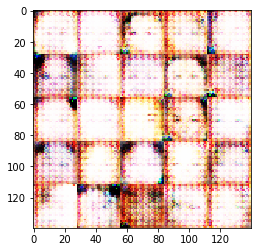

Epoch 1/1... Discriminator Loss: 0.6205... Generator Loss: 1.8285
Epoch 1/1... Discriminator Loss: 1.2685... Generator Loss: 0.5559
Epoch 1/1... Discriminator Loss: 0.5757... Generator Loss: 2.4744
Epoch 1/1... Discriminator Loss: 1.9574... Generator Loss: 0.2463
Epoch 1/1... Discriminator Loss: 1.8507... Generator Loss: 0.3996
Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 2.9175
Epoch 1/1... Discriminator Loss: 0.4199... Generator Loss: 2.6011
Epoch 1/1... Discriminator Loss: 0.5594... Generator Loss: 2.4469
Epoch 1/1... Discriminator Loss: 0.8674... Generator Loss: 0.9752
Epoch 1/1... Discriminator Loss: 1.2908... Generator Loss: 0.5688


Epoch 1/1... Discriminator Loss: 1.1853... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 0.6913... Generator Loss: 2.4310
Epoch 1/1... Discriminator Loss: 0.6350... Generator Loss: 1.6085
Epoch 1/1... Discriminator Loss: 0.9948... Generator Loss: 0.8761
Epoch 1/1... Discriminator Loss: 0.9458... Generator Loss: 1.7539
Epoch 1/1... Discriminator Loss: 0.6653... Generator Loss: 1.7188
Epoch 1/1... Discriminator Loss: 1.1616... Generator Loss: 1.5356
Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 1.4024
Epoch 1/1... Discriminator Loss: 0.9856... Generator Loss: 0.9210
Epoch 1/1... Discriminator Loss: 0.5494... Generator Loss: 2.3910


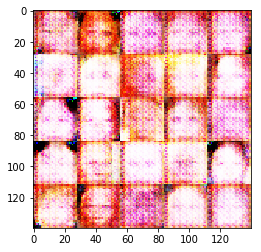

Epoch 1/1... Discriminator Loss: 1.3105... Generator Loss: 0.5482
Epoch 1/1... Discriminator Loss: 0.4339... Generator Loss: 4.0568
Epoch 1/1... Discriminator Loss: 0.9577... Generator Loss: 0.9916
Epoch 1/1... Discriminator Loss: 1.6805... Generator Loss: 0.3387
Epoch 1/1... Discriminator Loss: 1.3408... Generator Loss: 0.5408
Epoch 1/1... Discriminator Loss: 1.0121... Generator Loss: 0.9980
Epoch 1/1... Discriminator Loss: 1.8804... Generator Loss: 0.2881
Epoch 1/1... Discriminator Loss: 0.5721... Generator Loss: 1.7182
Epoch 1/1... Discriminator Loss: 0.8443... Generator Loss: 1.1251
Epoch 1/1... Discriminator Loss: 0.6890... Generator Loss: 2.7033


Epoch 1/1... Discriminator Loss: 0.9421... Generator Loss: 1.6654
Epoch 1/1... Discriminator Loss: 0.7793... Generator Loss: 1.2620
Epoch 1/1... Discriminator Loss: 0.8574... Generator Loss: 1.0173
Epoch 1/1... Discriminator Loss: 1.2730... Generator Loss: 1.1344
Epoch 1/1... Discriminator Loss: 0.4570... Generator Loss: 2.3430
Epoch 1/1... Discriminator Loss: 1.6202... Generator Loss: 0.3920
Epoch 1/1... Discriminator Loss: 2.1107... Generator Loss: 0.2097
Epoch 1/1... Discriminator Loss: 1.3334... Generator Loss: 0.4787
Epoch 1/1... Discriminator Loss: 1.1296... Generator Loss: 1.1208
Epoch 1/1... Discriminator Loss: 1.1252... Generator Loss: 0.8561


Epoch 1/1... Discriminator Loss: 1.0692... Generator Loss: 0.7854
Epoch 1/1... Discriminator Loss: 0.8928... Generator Loss: 1.0059
Epoch 1/1... Discriminator Loss: 1.5509... Generator Loss: 0.4133
Epoch 1/1... Discriminator Loss: 2.0042... Generator Loss: 0.2556
Epoch 1/1... Discriminator Loss: 0.6975... Generator Loss: 1.3385
Epoch 1/1... Discriminator Loss: 1.0892... Generator Loss: 3.0624
Epoch 1/1... Discriminator Loss: 0.4431... Generator Loss: 2.3286
Epoch 1/1... Discriminator Loss: 0.8234... Generator Loss: 1.0361
Epoch 1/1... Discriminator Loss: 1.0394... Generator Loss: 1.0745
Epoch 1/1... Discriminator Loss: 0.8455... Generator Loss: 1.1146


Epoch 1/1... Discriminator Loss: 0.9340... Generator Loss: 0.8960
Epoch 1/1... Discriminator Loss: 1.1931... Generator Loss: 1.3877
Epoch 1/1... Discriminator Loss: 0.6782... Generator Loss: 1.6331
Epoch 1/1... Discriminator Loss: 1.2094... Generator Loss: 0.6144
Epoch 1/1... Discriminator Loss: 0.8255... Generator Loss: 1.7462
Epoch 1/1... Discriminator Loss: 1.5063... Generator Loss: 2.3835
Epoch 1/1... Discriminator Loss: 2.9803... Generator Loss: 0.1178
Epoch 1/1... Discriminator Loss: 0.9438... Generator Loss: 2.8130
Epoch 1/1... Discriminator Loss: 0.5618... Generator Loss: 4.2852
Epoch 1/1... Discriminator Loss: 1.1098... Generator Loss: 0.7042


Epoch 1/1... Discriminator Loss: 1.3138... Generator Loss: 0.4887
Epoch 1/1... Discriminator Loss: 1.0173... Generator Loss: 1.5080
Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.5362
Epoch 1/1... Discriminator Loss: 2.7400... Generator Loss: 0.1099
Epoch 1/1... Discriminator Loss: 1.3379... Generator Loss: 0.6222
Epoch 1/1... Discriminator Loss: 0.7908... Generator Loss: 1.1774
Epoch 1/1... Discriminator Loss: 1.1514... Generator Loss: 0.8159
Epoch 1/1... Discriminator Loss: 0.3671... Generator Loss: 4.7874
Epoch 1/1... Discriminator Loss: 0.8826... Generator Loss: 0.9819
Epoch 1/1... Discriminator Loss: 1.7853... Generator Loss: 2.0605


Epoch 1/1... Discriminator Loss: 1.6073... Generator Loss: 3.0382
Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 0.5040
Epoch 1/1... Discriminator Loss: 0.6537... Generator Loss: 1.5956
Epoch 1/1... Discriminator Loss: 0.6290... Generator Loss: 1.7290
Epoch 1/1... Discriminator Loss: 1.5415... Generator Loss: 0.4385
Epoch 1/1... Discriminator Loss: 0.3789... Generator Loss: 6.0839
Epoch 1/1... Discriminator Loss: 1.2036... Generator Loss: 0.6665
Epoch 1/1... Discriminator Loss: 0.9642... Generator Loss: 0.8479
Epoch 1/1... Discriminator Loss: 1.7201... Generator Loss: 0.3419
Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 2.0664


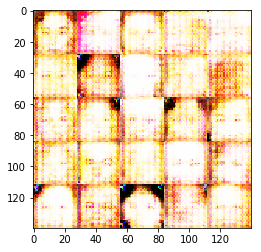

Epoch 1/1... Discriminator Loss: 0.7333... Generator Loss: 1.2446
Epoch 1/1... Discriminator Loss: 0.9585... Generator Loss: 1.1892
Epoch 1/1... Discriminator Loss: 0.7400... Generator Loss: 2.2200
Epoch 1/1... Discriminator Loss: 3.5644... Generator Loss: 0.0494
Epoch 1/1... Discriminator Loss: 0.8280... Generator Loss: 0.9769
Epoch 1/1... Discriminator Loss: 2.6225... Generator Loss: 0.1268
Epoch 1/1... Discriminator Loss: 0.9798... Generator Loss: 0.8024
Epoch 1/1... Discriminator Loss: 1.5492... Generator Loss: 0.4107
Epoch 1/1... Discriminator Loss: 0.8518... Generator Loss: 1.0801
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.4887


Epoch 1/1... Discriminator Loss: 1.1883... Generator Loss: 0.9872
Epoch 1/1... Discriminator Loss: 1.0214... Generator Loss: 0.8168
Epoch 1/1... Discriminator Loss: 1.5345... Generator Loss: 0.3996
Epoch 1/1... Discriminator Loss: 0.5941... Generator Loss: 2.0708
Epoch 1/1... Discriminator Loss: 1.5523... Generator Loss: 0.3753
Epoch 1/1... Discriminator Loss: 1.1454... Generator Loss: 0.6425
Epoch 1/1... Discriminator Loss: 0.9848... Generator Loss: 0.8593
Epoch 1/1... Discriminator Loss: 0.6440... Generator Loss: 1.7323
Epoch 1/1... Discriminator Loss: 2.4604... Generator Loss: 0.1413
Epoch 1/1... Discriminator Loss: 1.6199... Generator Loss: 0.3867


Epoch 1/1... Discriminator Loss: 0.6113... Generator Loss: 1.5916
Epoch 1/1... Discriminator Loss: 0.9912... Generator Loss: 0.9343
Epoch 1/1... Discriminator Loss: 0.4817... Generator Loss: 2.3576
Epoch 1/1... Discriminator Loss: 1.2332... Generator Loss: 0.5543
Epoch 1/1... Discriminator Loss: 1.5856... Generator Loss: 2.6209
Epoch 1/1... Discriminator Loss: 0.6207... Generator Loss: 2.2616
Epoch 1/1... Discriminator Loss: 1.5535... Generator Loss: 0.4543
Epoch 1/1... Discriminator Loss: 0.4116... Generator Loss: 3.7966
Epoch 1/1... Discriminator Loss: 0.8047... Generator Loss: 1.1171
Epoch 1/1... Discriminator Loss: 1.5947... Generator Loss: 0.3737


Epoch 1/1... Discriminator Loss: 0.9067... Generator Loss: 0.9383
Epoch 1/1... Discriminator Loss: 0.9322... Generator Loss: 1.1887
Epoch 1/1... Discriminator Loss: 1.2115... Generator Loss: 0.6159
Epoch 1/1... Discriminator Loss: 1.2700... Generator Loss: 0.5386
Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 0.4876
Epoch 1/1... Discriminator Loss: 2.1671... Generator Loss: 0.2351
Epoch 1/1... Discriminator Loss: 1.0570... Generator Loss: 0.8282
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.4666
Epoch 1/1... Discriminator Loss: 1.2765... Generator Loss: 0.5769
Epoch 1/1... Discriminator Loss: 1.0072... Generator Loss: 0.7521


Epoch 1/1... Discriminator Loss: 1.1025... Generator Loss: 0.7553
Epoch 1/1... Discriminator Loss: 0.7759... Generator Loss: 2.8067
Epoch 1/1... Discriminator Loss: 0.9488... Generator Loss: 1.0822
Epoch 1/1... Discriminator Loss: 0.5643... Generator Loss: 2.9201
Epoch 1/1... Discriminator Loss: 0.5331... Generator Loss: 2.6136
Epoch 1/1... Discriminator Loss: 1.2135... Generator Loss: 0.6586
Epoch 1/1... Discriminator Loss: 1.2926... Generator Loss: 3.6694
Epoch 1/1... Discriminator Loss: 1.2011... Generator Loss: 0.6073
Epoch 1/1... Discriminator Loss: 0.9173... Generator Loss: 1.7913
Epoch 1/1... Discriminator Loss: 0.8310... Generator Loss: 1.1252


Epoch 1/1... Discriminator Loss: 1.2513... Generator Loss: 2.8448
Epoch 1/1... Discriminator Loss: 0.5227... Generator Loss: 1.8630
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.4519
Epoch 1/1... Discriminator Loss: 1.3044... Generator Loss: 0.5298
Epoch 1/1... Discriminator Loss: 0.4943... Generator Loss: 1.9319
Epoch 1/1... Discriminator Loss: 1.1926... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 1.5436... Generator Loss: 0.3831
Epoch 1/1... Discriminator Loss: 0.6000... Generator Loss: 1.6283
Epoch 1/1... Discriminator Loss: 0.8497... Generator Loss: 1.6658
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.4559


Epoch 1/1... Discriminator Loss: 0.8434... Generator Loss: 1.0934
Epoch 1/1... Discriminator Loss: 1.0552... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 3.1433... Generator Loss: 3.9361
Epoch 1/1... Discriminator Loss: 1.8913... Generator Loss: 0.2789
Epoch 1/1... Discriminator Loss: 1.2837... Generator Loss: 0.5891
Epoch 1/1... Discriminator Loss: 1.9335... Generator Loss: 0.2399
Epoch 1/1... Discriminator Loss: 0.8798... Generator Loss: 1.1110
Epoch 1/1... Discriminator Loss: 0.4314... Generator Loss: 2.8557
Epoch 1/1... Discriminator Loss: 0.8866... Generator Loss: 1.2152
Epoch 1/1... Discriminator Loss: 0.8892... Generator Loss: 1.3463


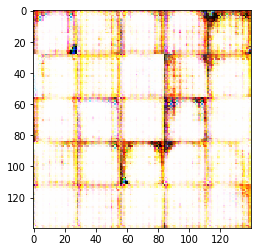

Epoch 1/1... Discriminator Loss: 0.8650... Generator Loss: 1.8465
Epoch 1/1... Discriminator Loss: 1.1500... Generator Loss: 0.8119
Epoch 1/1... Discriminator Loss: 1.6387... Generator Loss: 0.3498
Epoch 1/1... Discriminator Loss: 0.9285... Generator Loss: 0.9522
Epoch 1/1... Discriminator Loss: 0.9404... Generator Loss: 0.8924
Epoch 1/1... Discriminator Loss: 0.7398... Generator Loss: 1.1800
Epoch 1/1... Discriminator Loss: 2.0779... Generator Loss: 0.2043
Epoch 1/1... Discriminator Loss: 1.0655... Generator Loss: 1.1151
Epoch 1/1... Discriminator Loss: 0.7664... Generator Loss: 1.1008
Epoch 1/1... Discriminator Loss: 0.9571... Generator Loss: 0.8416


Epoch 1/1... Discriminator Loss: 1.4574... Generator Loss: 0.4268
Epoch 1/1... Discriminator Loss: 0.5508... Generator Loss: 1.9056
Epoch 1/1... Discriminator Loss: 0.8769... Generator Loss: 1.1564
Epoch 1/1... Discriminator Loss: 0.8604... Generator Loss: 1.2187
Epoch 1/1... Discriminator Loss: 1.1614... Generator Loss: 0.6432
Epoch 1/1... Discriminator Loss: 1.1966... Generator Loss: 1.6972
Epoch 1/1... Discriminator Loss: 1.5034... Generator Loss: 1.6611
Epoch 1/1... Discriminator Loss: 0.8509... Generator Loss: 1.4192
Epoch 1/1... Discriminator Loss: 1.5503... Generator Loss: 0.3613
Epoch 1/1... Discriminator Loss: 1.2981... Generator Loss: 0.5100


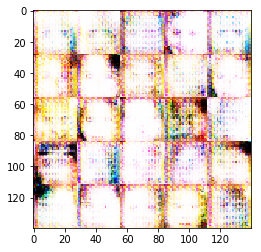

Epoch 1/1... Discriminator Loss: 0.5994... Generator Loss: 1.8120
Epoch 1/1... Discriminator Loss: 1.6621... Generator Loss: 2.6631
Epoch 1/1... Discriminator Loss: 1.5229... Generator Loss: 0.4043
Epoch 1/1... Discriminator Loss: 0.6497... Generator Loss: 1.6078
Epoch 1/1... Discriminator Loss: 0.8975... Generator Loss: 0.9796
Epoch 1/1... Discriminator Loss: 1.8891... Generator Loss: 0.2454
Epoch 1/1... Discriminator Loss: 1.1816... Generator Loss: 0.7424
Epoch 1/1... Discriminator Loss: 2.0531... Generator Loss: 0.2024
Epoch 1/1... Discriminator Loss: 1.1095... Generator Loss: 0.6849
Epoch 1/1... Discriminator Loss: 0.5976... Generator Loss: 3.3790


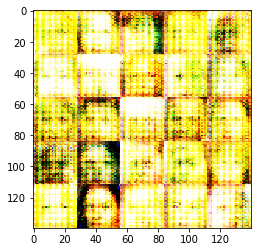

Epoch 1/1... Discriminator Loss: 1.6620... Generator Loss: 0.3465
Epoch 1/1... Discriminator Loss: 1.2520... Generator Loss: 0.6504


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.